## Heart Rate Variability Analysis with Latency Plots

Assumes Ch0 = Breath, Ch1 = Heart <br>
This script will crash with large files (> 20 min recordings) if run in Jupyter notebooks <br>
For large files, run in the python terminal<br>
For very large files, run on the High Performace Computing core (Research Bioinformatics, contact Marc Carlson or Glenn Morton)<br>

### User Input

In [1]:
# File variables
dir_in = r'C:\Users\haley\Dropbox\Code\Heartrate Variability'
dir_out = dir_in + r'\analyzed'
file_in = 'BL6_P15_0001.abf'

start_mins = 0.1 # in Minutes from the ABF file (use clampfit to find window)
end_mins = 0.14 # Last data point to analyze. -9999 indicates the whole file

# Exclusion criteria
threshold1 = 0.45     # min amplitude to signal a peak on Ch0 (half peak)
threshold2 = 0.02    # min amplitdue to signal a peak on Ch1

# Save Figure? 1 = yes, 0 = no
save = 1

### Add experiment Notes

* Opened the original file in Clampfit and sected a few regions of interest up to 5 min long for testing
* Analyzed data and parameters can be found in a subfolder of the input directory named "analyzed"

### Load Packages

In [2]:
import pyabf
import os
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, HTML

### Load Traces Into Python and Initialize Variables
  


In [3]:
# Configure internal variables
os.chdir (dir_in)
abf = pyabf.ABF(file_in) 
smpl = abf.dataPointsPerMs # Scale factor for reading the raw data into the graph (in ms - must be integer)
start = round(start_mins * 60 * 1000/smpl)
end = round(end_mins * 60 * 1000/smpl)
start_s = start_mins * 60
end_s = end_mins * 60 
start_ms = start_mins * 60/1000
end_ms = end_mins * 60/1000 

# Assemble meta data for parameters text file
meta_name = file_in.split('.abf')
exp_name = meta_name[0]
file_out = str(meta_name[0] + '_parameters.txt')
fig_name = exp_name + '_'
meta_date = datetime.now()
meta_date = 'Time of run =  ' + meta_date.strftime("%m/%d/%Y, %H:%M:%S")
time_mins = 'Analysis window (in minutes) = ' + str(start_mins) + ' , ' + str(end_mins)
time_s = 'Analysis window (in s) = ' + str(start_s) + ' , ' + str(end_s)
time_ms = 'Analysis window (in ms) = ' + str(start_ms) + ' , ' + str(end_ms)
time_dp ='Analysis window (in datapoints) = ' + str(start) + ' , ' + str(end)


### Basic Function Definitions

In [4]:
# Save a dataframe as a csv spreadsheet
def save_csv (df_out, file_out, dir_out):
    try:
        os.stat(dir_out)
    except:
        os.makedirs(dir_out)

    # Write data to file
    os.chdir(dir_out)
    df_out.to_csv(file_out, index = False)

    
# Save a figure/plot 
def save_fig (fig, file_name, dir_out):
    try:
        os.stat(dir_out)
    except:
        os.makedirs(dir_out)
    os.chdir(dir_out)
    fig.savefig (file_name, dpi= 300, facecolor='w', edgecolor='w',  
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches='tight', pad_inches=0.1,
        metadata=None)

    
# Get the start and end of a single breath
def get_breath (abf, start, end):
    if end == -9999:
        end = len(abf.sweepY)
    
    # Get baselines for Ch1 and Ch0
    abf.setSweep (sweepNumber = 0, channel = 0) # sets current channel to Ch1
    baseline = np.mean(abf.sweepY[:]) # average of the entire trace in Ch0
    breaths_start = []
    breaths_end = []
    i=0 # current datapoint
    while i < end:
        current = abf.sweepY[i]
        if current-baseline > threshold1:
            pt1 = i # starting datapoint of peak
            j = i
            while abf.sweepY[j]-baseline > threshold1/2:
                j = j+1
                i = i + 1   
            pt2 = j # end of peak
            breaths_start.append(pt1)
            breaths_end.append(pt2)
        i = i + 1        
    return breaths_start, breaths_end

    
# Get the start and end of a single heart peak
def get_heart (abf, start, end):
    if end == -9999:
        end = len(abf.sweepY)
    # Get baselines for Ch1 and Ch0
    abf.setSweep (sweepNumber = 0, channel = 1) # sets current channel to Ch1
    baseline = np.mean(abf.sweepY[:]) # average of the entire trace in Ch0
    heart_start = []
    heart_end = []
    i=0
    while i < end:
        current = abf.sweepY[i]
        if current-baseline > threshold2:
            pt3 = i
            j = i
            while abf.sweepY[j]-baseline > threshold2:
                j = j+1
                i = i + 1   
            pt4 = j
            heart_start.append(pt3)
            heart_end.append(pt4)
        i = i + 1
    return heart_start, heart_end


# Plot a single breath epoch    
def plot_breath (abf, start, end):
    fig, ax = plt.subplots(2,1, figsize=(8, 8), dpi = 100)
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['top'].set_visible(False)
    abf.setSweep (sweepNumber = 0, channel = 0)
    ax[0].plot (abf.sweepX[start:end], abf.sweepY[start:end], linestyle = 'solid')
    abf.setSweep (sweepNumber = 0, channel = 1)
    ax[1].plot (abf.sweepX[start:end], abf.sweepY[start:end], linestyle = 'solid')

    
# Plot single heart epoch   
def plot_heart (abf, start, end):
    fig, ax = plt.subplots(2,1, figsize=(8, 8), dpi = 100)
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['top'].set_visible(False)
    abf.setSweep (sweepNumber = 0, channel = 1)
    ax[0].plot (abf.sweepX[start:end], abf.sweepY[start:end], linestyle = 'solid')   
    abf.setSweep (sweepNumber = 0, channel = 0)
    ax[1].plot (abf.sweepX[start:end], abf.sweepY[start:end], linestyle = 'solid')
       

# Get peak amplitude and time for a single breath epoch         
def get_breath_peak (abf, breath1):
    abf.setSweep (sweepNumber = 0, channel = 0)
    breath_y = []   
    breath_x = []    # datapoints
    breath_time = [] # ms
    i = 0
    while i < len (breath1)-1:
        # Find breath peak y value
        breath_peak_y = max(abf.sweepY[breath1[i]:breath1[i+1]])
        breath_y.append(breath_peak_y)
        # Find breath peak x value
        for breath in range(breath1[i],breath1[i+1]):
            if abf.sweepY[breath] == breath_peak_y:
                breath_x.append(breath)
                breath_time.append(abf.sweepX[breath])
        i = i+1
    # Error handling in case no peak is found in the last epoch
    if len(breath_x) > len(breath_y):
        breath_x = breath_x[:-1] # Removes last value from x column because no matching y
        breath_time = breath_time[:-1] # Removes last value from x column because no matching y
    return breath_x,breath_time, breath_y


# Get peak amplitude and time of all heart peaks
def get_heart_peaks (abf, heart1):
    abf.setSweep (sweepNumber = 0, channel = 1)
    heart_y = []   
    heart_x = []    # datapoints
    heart_time = [] # ms
    i = 0
    while i < len (heart1)-1:
        # Find breath peak y value
        heart_peak_y = max(abf.sweepY[heart1[i]:heart1[i+1]])
        heart_y.append(heart_peak_y)
        
        # Find breath peak x value
        for heart in range(heart1[i],heart1[i+1]):
            if abf.sweepY[heart] == heart_peak_y:
                heart_x.append(heart)
                heart_time.append(abf.sweepX[heart])
        i = i+1
    # Error handling in case no peak is found in the last epoch
    if len(heart_x) > len(heart_y):
        heart_x = heart_x[:-1] # Removes last value from x column because no matching y
        heart_time = heart_time[:-1] # Removes last value from x column because no matching y
    return heart_x,heart_time, heart_y


# Get peak amplitude and time for a single heart epoch 
def get_heart_peak (abf, breath_x, breath1):
    abf.setSweep (sweepNumber = 0, channel = 1)
    heart_y = []   
    heart_x = []    # datapoints
    heart_time = [] # ms
    i = 1
    while i < len (breath1):
        # Find heart peak y value
        heart_peak_y = max(abf.sweepY[breath_x[i-1]:breath1[i]])
        heart_y.append(heart_peak_y)
        
        # Find heart peak x value
        for heart in range(breath_x[i-1],breath1[i]):
            if abf.sweepY[heart] == heart_peak_y:
                heart_x.append(heart)
                heart_time.append(abf.sweepX[heart])
        i = i+1
    # Error handling in case no peak is found in the last epoch
    if len(heart_x) > len(heart_y):
        heart_x = heart_x[:-1] # Removes last value from x column because no matching y
        heart_time = heart_time[:-1] # Removes last value from x column because no matching y
    return heart_x,  heart_time, heart_y


# Plot heart peaks against breath peaks without saving the figures
def plot_peaks (abf, breath1, breath_time, heart_time, breath_y, heart_y):
    # Plot Breath Epoch with Peak
    i = 0
    while i < len(breath1)-1:
   
        fig, ax = plt.subplots(2,1, figsize=(6, 8), dpi = 100)
        ax[0].spines['right'].set_visible(False)
        ax[0].spines['top'].set_visible(False)
        ax[1].spines['right'].set_visible(False)
        ax[1].spines['top'].set_visible(False)
    
        #Plot Breath Peaks
        abf.setSweep (sweepNumber = 0, channel = 0)
        x_values = abf.sweepX[breath1[i] : breath1[i+1]]
        y_values = abf.sweepY[breath1[i]:breath1[i+1]]
        x_peak = breath_time[i]-0.005
        y_peak = breath_y[i]+ threshold1 * 0.1
        ax[0].plot (x_values, y_values , linestyle = 'solid')
        ax[0].annotate('*', xy=(x_peak, y_peak), size = 25, color = 'black') 
        ax[0].set_ylim(min(y_values) - threshold1 * 0.5 , max(y_values) + threshold1 * 0.5)
    
        # Plot Heart Peaks
        abf.setSweep (sweepNumber = 0, channel = 1)
        x_values = abf.sweepX[breath1[i]:breath1[i+1]]
        y_values = abf.sweepY[breath1[i]:breath1[i+1]]
        x_peak = heart_time[i]-0.005
        y_peak = heart_y[i]+ threshold2 *0.1
        ax[1].plot (x_values, y_values , linestyle = 'solid')
        ax[1].annotate('*', xy=(x_peak, y_peak), size = 25, color = 'black') 
        ax[1].set_ylim(min(y_values) - threshold2 * 0.5 , max(y_values) + threshold2 * 0.5)
    
        # 0.005 adjustment (1 dp = 0.005 seconds) 
        # Takes into account that the plot starts at data point #1, but arrays in python start at #0
        # Without the adjustment, the asterisk would be shifted one datapoint ahead of the actual peak (+ 0.005s)
        # Y axis is also adjusted on peak annotation by shifting up 10% to avoid obscuring the actual data
        # Y axis limits are set to 50% of threshold above max and min Y values
        
        i = i + 1

# Plot heart peaks against breath peaks and save the figures
def save_peaks (abf, breath1, breath_time, heart_time, breath_y, heart_y):
    # Plot Breath Epoch with Peak
    i = 0
    while i < len(breath1)-1:
   
        fig, ax = plt.subplots(2,1, figsize=(6, 8),  dpi = 100)
        plt.ioff()
        ax[0].spines['right'].set_visible(False)
        ax[0].spines['top'].set_visible(False)
        ax[0].spines['bottom'].set_visible(False)
        ax[1].spines['right'].set_visible(False)
        ax[1].spines['top'].set_visible(False)
    
        #Plot Breath Peaks
        abf.setSweep (sweepNumber = 0, channel = 0)
        x_values = abf.sweepX[breath1[i] : breath1[i+1]]
        y_values = abf.sweepY[breath1[i]:breath1[i+1]]
        x_peak = breath_time[i]-0.005
        y_peak = breath_y[i]+ threshold1 * 0.1
        ax[0].plot (x_values, y_values , linestyle = 'solid')
        ax[0].annotate('*', xy=(x_peak, y_peak), size = 25, color = 'black') 
        ax[0].set_ylim(min(y_values) - threshold1 * 0.5 , max(y_values) + threshold1 * 0.5)
        ax[0].set_xticks([])
    
        # Plot Heart Peaks
        abf.setSweep (sweepNumber = 0, channel = 1)
        x_values = abf.sweepX[breath1[i]:breath1[i+1]]
        y_values = abf.sweepY[breath1[i]:breath1[i+1]]
        x_peak = heart_time[i]-0.005
        y_peak = heart_y[i]+ threshold2 *0.1
        ax[1].plot (x_values, y_values , linestyle = 'solid')
        ax[1].annotate('*', xy=(x_peak, y_peak), size = 25, color = 'black') 
        ax[1].set_ylim(min(y_values) - threshold2 * 0.5 , max(y_values) + threshold2 * 0.5)
    
        # 0.005 adjustment (1 dp = 0.005 seconds) 
        # Takes into account that the plot starts at data point #1, but arrays in python start at #0
        # Without the adjustment, the asterisk would be shifted one datapoint ahead of the actual peak (+ 0.005s)
        # Y axis is also adjusted on peak annotation by shifting up 10% to avoid obscuring the actual data
        # Y axis limits are set to 50% of threshold above max and min Y values
        
        save_name = fig_name + str(i)
        save_fig (fig, save_name, dir_out)
        
        i = i + 1
        


### Assemble experiment metadata

In [5]:
# Construct a dataframe to store metadata
df_meta = pd.DataFrame()
df_meta['Parameter'] = ['date','file_in', 'file_out', 'dir_out', 'time_mins', 'time_s', 'time_ms', 'time datapoints']
df_meta['Value'] = [meta_date,file_in,file_out,dir_out,time_mins,time_s,time_ms,time_dp]

# Display and save the metadata
display(HTML(df_meta.to_html()))
save_csv (df_meta, file_out, dir_out)

,Parameter,Value
0,date,"Time of run = 12/20/2019, 10:00:08"
1,file_in,BL6_P15_0001.abf
2,file_out,BL6_P15_0001_parameters.txt
3,dir_out,C:\Users\haley\Dropbox\Code\Heartrate Variabil...
4,time_mins,"Analysis window (in minutes) = 0.1 , 0.14"
5,time_s,"Analysis window (in s) = 6.0 , 8.4"
6,time_ms,"Analysis window (in ms) = 0.006 , 0.0084000000..."
7,time datapoints,"Analysis window (in datapoints) = 3000 , 4200"


# Examples of Analysis

### Get all breath peaks

In [6]:
# Define the Function
def get_all_breath_peaks (abf, start, end):
    breath1, breath2 = get_breath (abf, start, end) # Get Breath Epoch
    breath_x, breath_ms, breath_y = get_breath_peak (abf, breath1) # Get Breath Peaks
    df_breaths = pd.DataFrame()                # Assemble data for output
    df_breaths['breath_peaks_x'] = breath_x    # Time in datapoints of the breath peak
    df_breaths['breath_peaks_ms'] = breath_ms  # Time in ms of the breath peak
    df_breaths['breath_peaks_y'] = breath_y    # Amplitdue of the breath peak 
    display(HTML(df_breaths.to_html()))        # Display the results onscreen
    save_csv(df_breaths, exp_name + '_all_breaths.csv', dir_out)  # Save the results in a csv spreadsheet
    return df_breaths  # results are returned to the calling function


# Run the Function
df_breaths = get_all_breath_peaks(abf, start, end)  # df_breaths catches the 'df_breaths' returned by function

,breath_peaks_x,breath_peaks_ms,breath_peaks_y
0,57,0.0285,0.668030
1,574,0.2870,0.707092
2,1111,0.5555,0.769043
3,1644,0.8220,0.691833
4,2223,1.1115,0.648193
5,2780,1.3900,0.631104
6,3338,1.6690,0.574951


### Calculate Breathing Rate

In [7]:
# Definte the function
# Have to run get_all_breath_peaks() first
# df_breaths is returned by get_all_breath_peaks()
def get_breath_rate (df_breaths, start_s, end_s):
    breath_num = len(df_breaths.breath_peaks_x)
    epoch_length = end_s - start_s
    breath_rate = breath_num/epoch_length   
    df_breath_rate = pd.DataFrame([{'Parameter': 'Number of Breaths', 'Value': breath_num}, 
                                   {'Parameter': 'Epoch Length (s)', 'Value': epoch_length}, 
                                   {'Parameter': 'Breath Rate (breaths/s)', 'Value': breath_rate}])
    return df_breath_rate


# Run the function and save the output to the breath_rate variable
df_breath_rate = get_breath_rate (df_breaths, start_s, end_s)

# Print the data to screen
display (HTML(df_breath_rate.to_html()))

# Add data to metadata
df_meta = df_meta.append(df_breath_rate)

# Display metadata with breath rate added
display(HTML(df_meta.to_html()))

,Parameter,Value
0,Number of Breaths,7.000000
1,Epoch Length (s),2.400000
2,Breath Rate (breaths/s),2.916667


,Parameter,Value
0,date,"Time of run = 12/20/2019, 10:00:08"
1,file_in,BL6_P15_0001.abf
2,file_out,BL6_P15_0001_parameters.txt
3,dir_out,C:\Users\haley\Dropbox\Code\Heartrate Variabil...
4,time_mins,"Analysis window (in minutes) = 0.1 , 0.14"
5,time_s,"Analysis window (in s) = 6.0 , 8.4"
6,time_ms,"Analysis window (in ms) = 0.006 , 0.0084000000..."
7,time datapoints,"Analysis window (in datapoints) = 3000 , 4200"
0,Number of Breaths,7
1,Epoch Length (s),2.4


### Get all heart peaks

In [8]:
# Define the Function
def get_all_heart_peaks (abf, start, end):
    heart1, heart2 = get_heart (abf, start, end) # Get heart Epochs    
    heart_x, heart_ms, heart_y = get_heart_peaks (abf, heart1) # Get Heart Peaks
    df_heart = pd.DataFrame()               # Dataframe for analyzed data
    df_heart['heart_peaks_x'] = heart_x    # Time in datapoints of each heart peak
    df_heart['heart_peaks_ms'] = heart_ms  # Time in ms of each heart peak
    df_heart['heart_peaks_y'] = heart_y    # Amplitude of each heart peak
    display(HTML(df_heart.to_html()))       # Display the heart peak data onscreen
    save_csv(df_heart, exp_name + '_all_hearts.csv', dir_out)  # Save the heart peak data to file
    return df_heart  # returns the heart peak data as a variable

# Run the function
df_heart = get_all_heart_peaks(abf,start,end)  # df_heart catches the returned 'df_heart' variable from the function



,heart_peaks_x,heart_peaks_ms,heart_peaks_y
0,9,0.0045,0.076599
1,20,0.0100,0.039368
2,191,0.0955,0.069885
3,372,0.1860,0.067139
4,551,0.2755,0.032654
5,559,0.2795,0.067444
6,740,0.3700,0.074158
7,765,0.3825,0.034485
8,931,0.4655,0.061035
9,1121,0.5605,0.066833


### Calculate Heart Rate

In [9]:
# Definte the function
# Have to run get_all_heart_peaks() first
# df_heart is returned by get_all_heart_peaks()
def get_heart_rate (df_heart, start_s, end_s):
    heart_num = len(df_heart.heart_peaks_x)
    epoch_length = end_s - start_s
    heart_rate = heart_num/epoch_length   
    df_heart_rate = pd.DataFrame([{'Parameter': 'Number of Heartbeats', 'Value': heart_num}, 
                                   {'Parameter': 'Epoch Length (s)', 'Value': epoch_length}, 
                                   {'Parameter': 'Heart Rate (peaks/s)', 'Value': heart_rate}])
    return df_heart_rate


# Run the function and save the output to the heart_rate variable
df_heart_rate = get_heart_rate (df_heart, start_s, end_s)

# Print the data to screen
display (HTML(df_heart_rate.to_html()))

# Add data to metadata
df_meta = df_meta.append(df_heart_rate)

# Display metadata with breath rate added
display(HTML(df_meta.to_html()))

,Parameter,Value
0,Number of Heartbeats,43.000000
1,Epoch Length (s),2.400000
2,Heart Rate (peaks/s),17.916667


,Parameter,Value
0,date,"Time of run = 12/20/2019, 10:00:08"
1,file_in,BL6_P15_0001.abf
2,file_out,BL6_P15_0001_parameters.txt
3,dir_out,C:\Users\haley\Dropbox\Code\Heartrate Variabil...
4,time_mins,"Analysis window (in minutes) = 0.1 , 0.14"
5,time_s,"Analysis window (in s) = 6.0 , 8.4"
6,time_ms,"Analysis window (in ms) = 0.006 , 0.0084000000..."
7,time datapoints,"Analysis window (in datapoints) = 3000 , 4200"
0,Number of Breaths,7
1,Epoch Length (s),2.4


### Get Heart Peak Following a Breath Peak

In [10]:
# Calls on the functions made above to find all heart and breath peaks
breath1, breath2 = get_breath (abf, start, end)                 # Get Breath Epochs
breath_x, breath_ms, breath_y = get_breath_peak (abf, breath1)  # Get all Breath Peaks
heart1, heart2 = get_heart (abf, start, end)                    # Get heart Epochs
heart_x, heart_ms, heart_y = get_heart_peaks (abf, heart1)      # Get Heart Peaks

# Find 1st heart peak after each breath peak based on tables generated above
i = 0
next_heart_x = []
next_heart_ms = []
next_heart_y = []
for x in breath_x:
    j = x+1
    if j > heart_x[i]:
        while j > heart_x[i]: 
            i = i + 1
    j = j + 1
    next_heart_x.append(heart_x[i])
    next_heart_ms.append(heart_ms[i])
    next_heart_y.append(heart_y[i])

# Assemble output with the amplitude and time of the next heart peak following each breath peak    
df = pd.DataFrame()
df['breath_peak_x'] = breath_x             # Time in datapoints of the breath peak
df['breath_peak_ms'] = breath_ms           # Time in ms of the breath peak
df['breath_peak_y'] = breath_y             # Amplitude of the breath peak
df['next_heart_peak_x'] = next_heart_x     # Time in datapoints of the next heartbeat after a breath
df['next_heart_peak_ms'] = next_heart_ms   # Time in ms of the next heartbeat after a breath
df['next_heart_peak_y'] = next_heart_y     # Amplitude of the next heartbeat after a breath

display(HTML(df.to_html()))

# Save data to a csv (Comma Separated Values) Spreadsheet that can be opened in Excel
save_csv(df, exp_name + '_breath_heart.csv', dir_out)

,breath_peak_x,breath_peak_ms,breath_peak_y,next_heart_peak_x,next_heart_peak_ms,next_heart_peak_y
0,57,0.0285,0.668030,191,0.0955,0.069885
1,574,0.2870,0.707092,740,0.3700,0.074158
2,1111,0.5555,0.769043,1121,0.5605,0.066833
3,1644,0.8220,0.691833,1670,0.8350,0.072937
4,2223,1.1115,0.648193,2239,1.1195,0.073853
5,2780,1.3900,0.631104,2803,1.4015,0.065613
6,3338,1.6690,0.574951,3370,1.6850,0.071716


### Plot Heart Peaks Following a Breath Peak (Limited to <20 breaths)

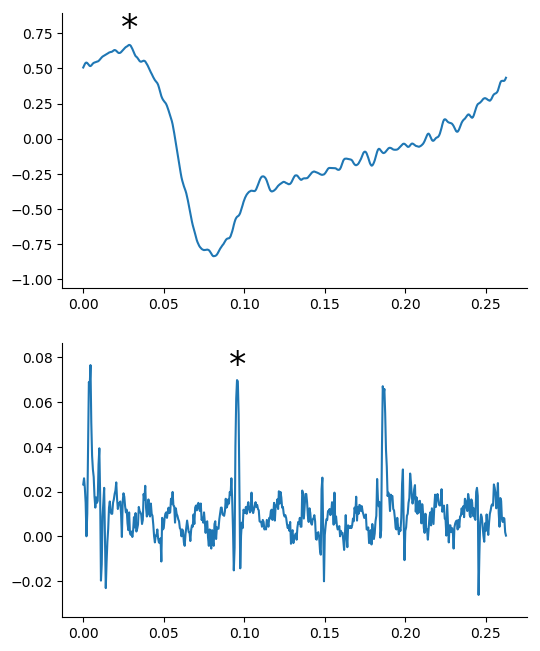

In [11]:
# Plot heart peak relative to breath peak
# Only for <20 breaths or they won't display in Jupyter Notebooks
# plot_range specifies the breaths you want to plot starting at 0, exclusive
# Example: 'breath1[0,4]' Plots breaths 1-3
plot_peaks (abf, breath1[0:2], breath_ms, next_heart_ms, breath_y, next_heart_y)


### Plot and Save Heart Peaks After a Breath (Limited to < 20 breaths)

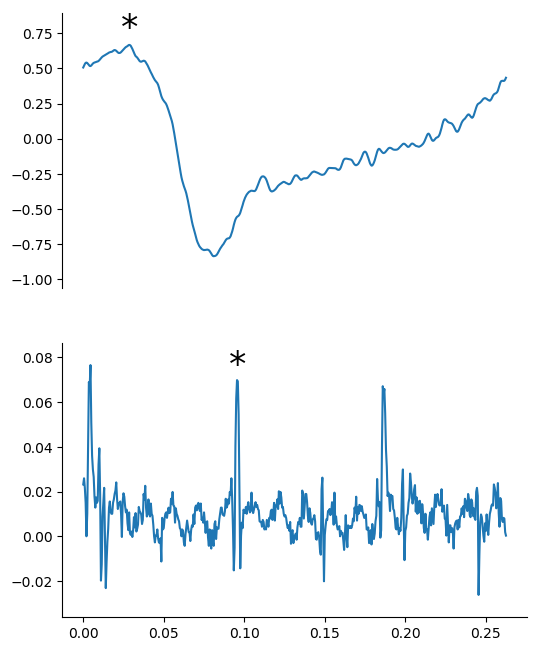

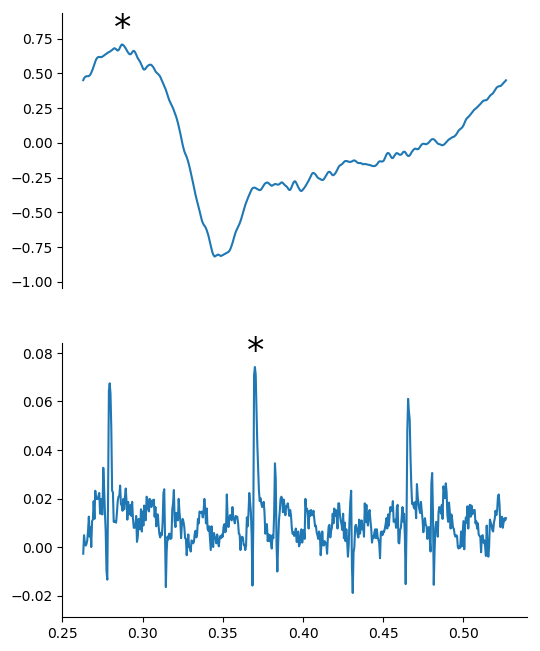

In [12]:
# Plot heart peak relative to breath peak
# Only for < 20 breaths or they won't display in Jupyter Notebooks
# plot_range specifies the breaths you want to plot starting at 0, exclusive
# Example: 'breath1[0,4]' Plots breaths 1-3
save_peaks (abf, breath1[0:3], breath_ms, next_heart_ms, breath_y, next_heart_y)

### Calculate Latency between breath spike and heart spike

In [13]:
df2 = df.copy() # Always work with a copy of the original dataframe to prevent overwriting data

latencies_dp = []
latencies_ms = []

i = 0
while i < len(df2.breath_peak_x):
    latency_dp = df2.next_heart_peak_x[i] - df2.breath_peak_x[i]
    latency_ms = df2.next_heart_peak_ms[i] - df2.breath_peak_ms[i]
    latencies_dp.append(latency_dp)
    latencies_ms.append(latency_ms)
    i = i + 1
        
# Add latencies to the csv file
df['latency_dp'] = latencies_dp
df['latency_ms'] = latencies_ms
save_csv(df, exp_name + '_breath_heart.csv', dir_out)
display(HTML(df.to_html()))



,breath_peak_x,breath_peak_ms,breath_peak_y,next_heart_peak_x,next_heart_peak_ms,next_heart_peak_y,latency_dp,latency_ms
0,57,0.0285,0.668030,191,0.0955,0.069885,134,0.0670
1,574,0.2870,0.707092,740,0.3700,0.074158,166,0.0830
2,1111,0.5555,0.769043,1121,0.5605,0.066833,10,0.0050
3,1644,0.8220,0.691833,1670,0.8350,0.072937,26,0.0130
4,2223,1.1115,0.648193,2239,1.1195,0.073853,16,0.0080
5,2780,1.3900,0.631104,2803,1.4015,0.065613,23,0.0115
6,3338,1.6690,0.574951,3370,1.6850,0.071716,32,0.0160


### Plot the latency with heart-breath peaks

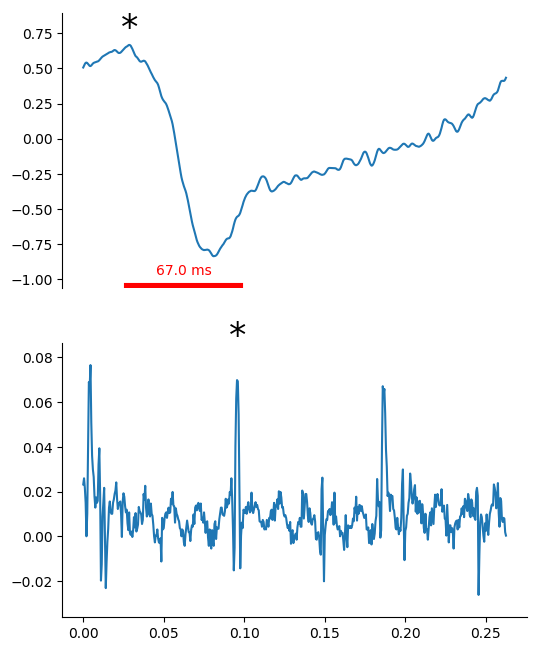

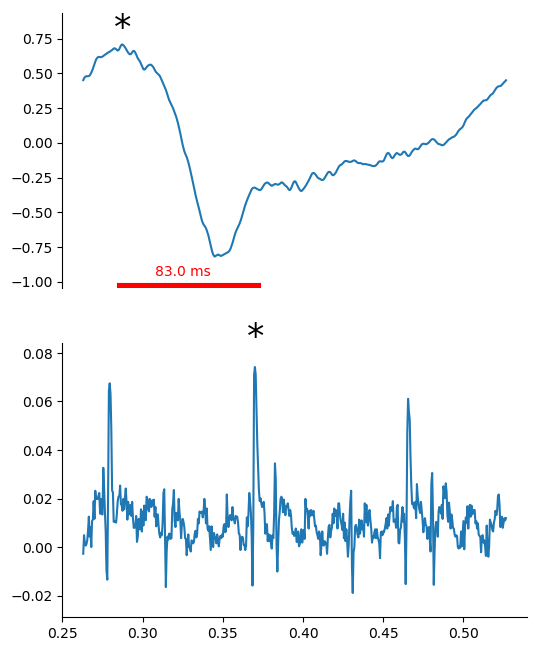

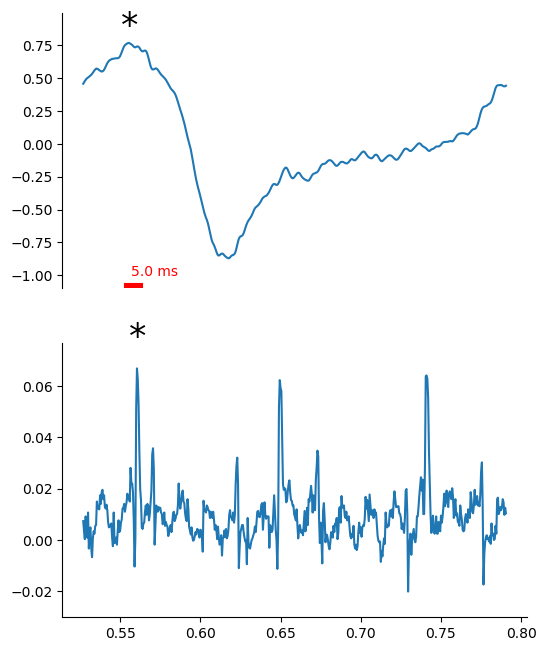

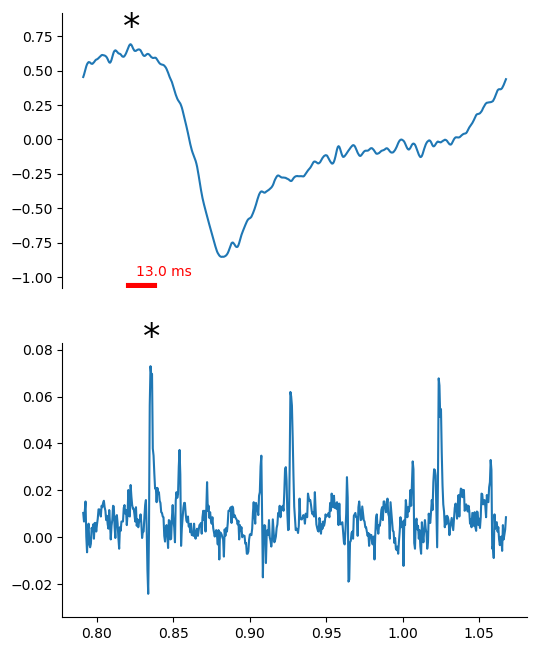

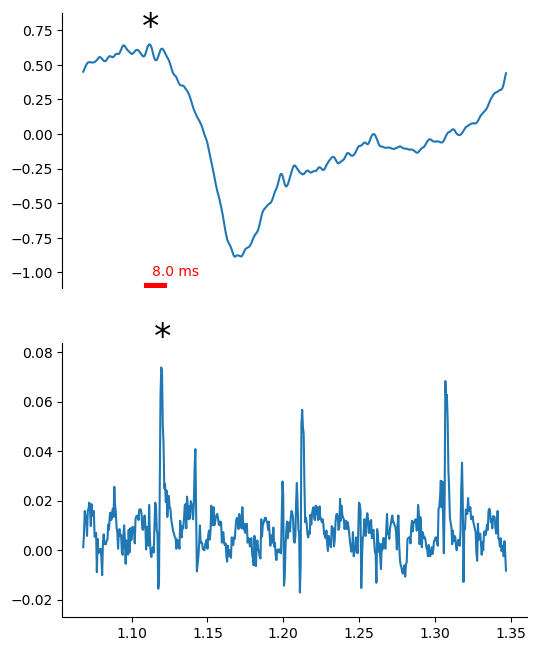

In [14]:
# Plot heart peaks against breath peaks without saving the figures
def plot_peaks (abf, breath1, breath_time, heart_time, breath_y, heart_y, latency):
    # Plot Breath Epoch with Peak
    i = 0
    while i < len(breath1)-1:
   
        fig, ax = plt.subplots(2,1, figsize=(6, 8), dpi = 100)
        ax[0].spines['right'].set_visible(False)
        ax[0].spines['top'].set_visible(False)
        ax[0].spines['bottom'].set_visible(False)
        ax[1].spines['right'].set_visible(False)
        ax[1].spines['top'].set_visible(False)
        
    
        #Plot Breath Peaks
        abf.setSweep (sweepNumber = 0, channel = 0)
        x_values1 = abf.sweepX[breath1[i] : breath1[i+1]]
        y_values1 = abf.sweepY[breath1[i]:breath1[i+1]]
        x_peak1 = breath_time[i]-0.005
        y_peak1 = breath_y[i]+ threshold1 * 0.1
        ax[0].plot (x_values1, y_values1 , linestyle = 'solid')
        ax[0].annotate('*', xy=(x_peak1, y_peak1), size = 25, color = 'black') 
        y_min1 = min(y_values1) - threshold1 * 0.5
        y_max1 = max(y_values1) + threshold1 * 0.5
        ax[0].set_ylim(y_min1, y_max1)
    
        # Plot Heart Peaks
        abf.setSweep (sweepNumber = 0, channel = 1)
        x_values2 = abf.sweepX[breath1[i]:breath1[i+1]]
        y_values2 = abf.sweepY[breath1[i]:breath1[i+1]]
        x_peak2 = heart_time[i]-0.005
        y_peak2 = heart_y[i]+ threshold2 *0.1
        y_min2 = min(y_values2) - threshold2 * 0.5
        y_max2 = max(y_values2) + threshold2 * 0.5
        ax[1].set_ylim(y_min2 , y_max2)
        ax[1].plot (x_values2, y_values2 , linestyle = 'solid')
        ax[1].annotate('*', xy=(x_peak2,  max(y_values2) + threshold2 * 0.4), size = 25, color = 'black') 
        
    
        # 0.005 adjustment (1 dp = 0.005 seconds) 
        # Takes into account that the plot starts at data point #1, but arrays in python start at #0
        # Without the adjustment, the asterisk would be shifted one datapoint ahead of the actual peak (+ 0.005s)
        # Y axis is also adjusted on peak annotation by shifting up 10% to avoid obscuring the actual data
        # Y axis limits are set to 50% of threshold above max and min Y values
        
        # Annotate the latency
        ax[0].plot ([breath_time[i], heart_time[i]], [y_min1, y_min1] , linestyle = 'solid', color = 'red', lw = 8)
        y_min3 = min(y_values1) - threshold1 * 0.3
        ax[0].annotate(str(round(latency[i]*1000, 10)) + ' ms', xy=(breath_time[i] + (heart_time[i]-breath_time[i])/4, y_min3), size = 10, color = 'red') 
        ax[0].set_xticks([])
        i = i + 1
        
        
plot_peaks (abf, breath1[0:6], breath_ms, next_heart_ms, breath_y, heart_y, latencies_ms)